In [1]:
import torch
from datasets import IndexedDataset, WeightedDataset
from torch.utils.data import DataLoader, DistributedSampler

from utils import get_args
from architectures import load_architecture

from samplers import DistributedCustomSampler
from losses import trades_loss
from tqdm.notebook import tqdm
from architectures import load_architecture, load_statedict, add_lora

args = get_args()
args.arch = 'LeNet5'
args.dataset = 'MNIST'
args.selection_method = 'random'

# Example Usage

model, target_layers = load_architecture(args)
model.to('cuda')

# statedict = load_statedict(args)
# model.load_state_dict(statedict)
# add_lora(target_layers, model)

args.pruning_ratio = 0
args.delta = 1
args.batch_size = 64
args.pruning_strategy = 'random'
args.batch_strategy = 'random'
args.sample_size= 128

# train_dataset = IndexedDataset()
print('init weighted dataset')
train_dataset = WeightedDataset(args, train=True, prune_ratio = args.pruning_ratio,  )

train_sampler = DistributedCustomSampler(args, train_dataset, num_replicas=2, rank=0, drop_last=True)

print('init dataloder')
trainloader = DataLoader(train_dataset, batch_size=None, sampler = train_sampler,) 

./data
init weighted dataset
60000 60000
init dataloder


In [2]:
from losses import get_loss, get_eval_loss

iterations = 2
rank = 'cuda'

optimizer = torch.optim.SGD( model.parameters(),lr=args.init_lr, weight_decay=args.weight_decay, momentum=args.momentum, nesterov=True, )

for iteration in range(iterations):

    model.train()
    train_sampler.set_epoch(iteration)

    for batch_id, batch in tqdm(enumerate( trainloader ) ):

        optimizer.zero_grad()

        data, target, idxs = batch

        # print(idxs)

        data, target = data.to(rank), target.to(rank) 
         
        loss_values, clean_values, robust_values, logits_nat, logits_adv = get_loss(args, model, data, target, optimizer)
        # print(logits_adv.shape)
        # print(logits_nat.shape)
        # assert torch.isfinite(loss_values).all(), "Loss contains NaNs!"
        # assert torch.isfinite(logits_nat).all(), "Logits_nat contains NaNs!"
        # assert torch.isfinite(logits_adv).all(), "Logits_adv contains NaNs!"

        # train_dataset.update_scores(iteration, idxs,loss_values)
        train_dataset.update_scores(rank, idxs, clean_values, robust_values, loss_values, logits_nat, logits_adv)

        train_dataset.global_scores2[iteration][idxs] = loss_values.detach().cpu()

        loss = train_dataset.compute_loss(idxs, loss_values)

        loss.backward()
        optimizer.step()

pruning
remove tail
process


0it [00:00, ?it/s]

subset index: 64 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63]) original indices: tensor([ 90,  58,  86, 122,  68,  66,  62,  80,  52, 124,  44,   4,  22,  56,
        108,   8,  20,  70, 104,  92,  60,  14,  28,  54, 126, 110,  82,  84,
        116,  36, 120,  64,  30,  10,  32,  40, 112,  16,  26,  50,  74,  34,
         96, 102, 114,  76,   2,  24,  98,  48,  12,  46,  72, 100,  42,  38,
         18,  78, 118,   6,   0, 106,  94,  88], device='cuda:0')

subset index: 64 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 

0it [00:00, ?it/s]

subset index: 0 tensor([], dtype=torch.int64) original indices: tensor([ 48,  78, 104,  54,  88,   4,  42, 124,  82, 100,  76, 108,  70,  52,
        114,  98,   6,  80,  72,  20, 112,  38,  68, 120,  34, 110, 106,  96,
         66, 102,  62, 118,  26,  44,  64,  60,  92,  46,   8,  28,  58,  56,
         84, 116,  94,  36, 126,  40,  50,  12,  90,  14, 122,   2,  32,   0,
         30,  10,  22,  18,  16,  24,  86,  74], device='cuda:0')

subset index: 0 tensor([], dtype=torch.int64) original indices: tensor([168, 198, 190, 234, 186, 188, 226, 160, 246, 230, 242, 252, 138, 150,
        152, 132, 228, 140, 170, 216, 224, 154, 162, 130, 194, 254, 176, 248,
        156, 214, 184, 212, 236, 232, 218, 250, 220, 148, 240, 192, 144, 204,
        166, 202, 182, 200, 238, 206, 134, 146, 172, 208, 244, 180, 142, 174,
        196, 222, 178, 136, 128, 158, 164, 210], device='cuda:0')

subset index: 0 tensor([], dtype=torch.int64) original indices: tensor([350, 306, 294, 326, 358, 374, 310, 284, 27

torch.Size([10, 60000])


  0%|          | 0/100 [00:00<?, ?it/s]

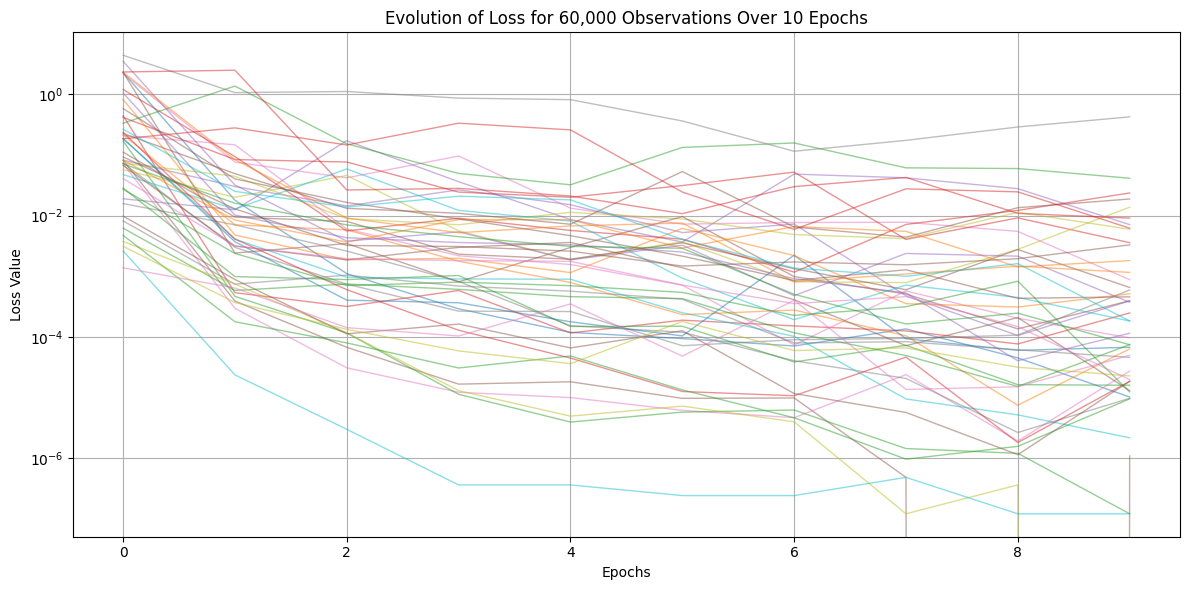

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a sample tensor with dimensions (10, 60000)
# Each of the 10 rows represents an epoch, and each column represents a loss value for one of the 60,000 observations.
np.random.seed(0)  # For reproducibility
tensor = train_dataset.global_scores2 #np.random.rand(10, 60000)  # Simulating loss values

# Sampling 1000 observations from the 60,000
print(tensor.shape)
sample_indices = np.random.choice(tensor.shape[1], size=100, replace=False)

sampled_tensor = tensor[:, sample_indices]

# Plotting the evolution of the loss for the 60,000 observations over 10 epochs
plt.figure(figsize=(12, 6))

# Plotting each observation's loss over the 10 epochs
for i in tqdm(range(sampled_tensor.shape[1])):
    plt.plot(range(10), sampled_tensor[:, i], alpha=0.5, linewidth=1)  # Plotting with low opacity and thin lines for clarity

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.yscale('log')  # Setting y-axis to log scale

plt.title('Evolution of Loss for 60,000 Observations Over 10 Epochs')
plt.grid(True)
plt.tight_layout()

plt.show()


In [17]:
shape = np.array([1,1,1,1])
scale = np.array([1,1,1,1])

s = np.random.gamma(shape, scale)

print(s)

[1.05206389 1.03931975 1.10199592 0.37097939]


In [ ]:

# for i in range(len(train_dataset)):
#     print(train_dataset[i])
import numpy as np

def obtain_latent_dataset(model, dataset, batch_size=32):

    # Assuming the dataset is a list or similar iterable with a known length
    num_samples = len(dataset)

    # Assume the dimensionality of the latent representation can be determined from one sample
    image,label, idx = dataset[0]
    image = torch.Tensor(image).to('cuda').unsqueeze(0)
    print(image.shape)
    first_latent_rep = model.get_latent_representation(image)
    latent_dim = first_latent_rep.shape[1]
    print(first_latent_rep.shape)
        
    # Preallocate the array for the latent representations
    latent_dataset = torch.zeros((num_samples, latent_dim))


    for i in tqdm( range(0, num_samples, batch_size) ):
        # Get the current batch of data
        batch_indices = list(range(i, min(i + batch_size, num_samples)))
        images,labels,idxs = dataset[batch_indices]
        images = images.to('cuda')
            
        # Process the batch to get latent representations
        batch_latent_reps = model.get_latent_representation(images) 
            
        # Store the results in the preallocated array
        latent_dataset[i:i + batch_size] = batch_latent_reps.detach().cpu()

    return latent_dataset

features =  obtain_latent_dataset(model,train_dataset,64)
train_dataset.define_latent_features(features)

